<a href="https://colab.research.google.com/github/rizqul/PukulEnam-recommend-system/blob/main/KlasifikasiTopikBerita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 16.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

import string
import nltk
import re
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
articles_df = pd.read_csv('https://raw.githubusercontent.com/anscc2/Dataset/main/historical_articles.csv')
articles_df.head()

,Judul,Jenis
0,Terapi Metadon Untuk Pecandu Heroin,Kesehatan
1,Tesla Menuntut Seorang Influencer Vlogger Asal...,Teknologi
2,Lebih Melek pasar di Imlek 2022!,Finansial
3,Indonesia Resmi Masuk Gelombang Tiga COVID-19,Kesehatan
4,"Bocoran Render Desain Xiaomi 12 Mini, Flagship...",Teknologi


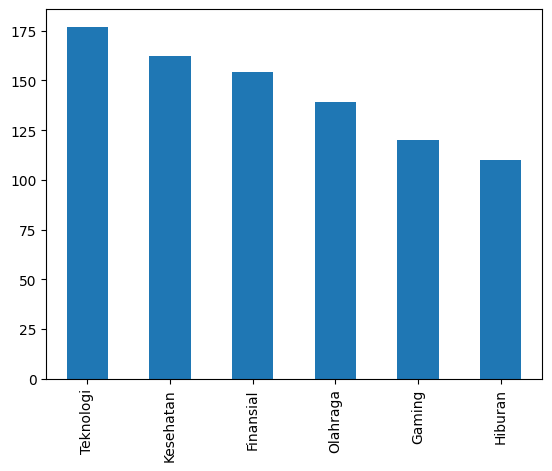

In [4]:
jenis_counts = pd.Series(articles_df['Jenis']).value_counts()
jenis_counts.plot(kind='bar')
plt.show()

In [5]:
def clean_text(text):
  # Remove puncuation
  text = text.translate(string.punctuation)

  # Convert words to lower case and split them
  text = text.lower().split()

  # Remove stop words
  stops = set(stopwords.words("indonesian"))
  text = [w for w in text if not w in stops and len(w) >= 3]
  text = " ".join(text)

  # Clean the text
  text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)

  # Stemming
  text = text.split()
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  stemmed_words = [stemmer.stem(word) for word in text]
  text = " ".join(stemmed_words)

  return text

articles_df['clean_text'] = articles_df['Judul'].map(lambda x: clean_text(x))

In [6]:
articles_df.head()

,Judul,Jenis,clean_text
0,Terapi Metadon Untuk Pecandu Heroin,Kesehatan,terapi metadon candu heroin
1,Tesla Menuntut Seorang Influencer Vlogger Asal...,Teknologi,tesla tuntut influencer vlogger tiongkok alas
2,Lebih Melek pasar di Imlek 2022!,Finansial,melek pasar imlek 2022
3,Indonesia Resmi Masuk Gelombang Tiga COVID-19,Kesehatan,indonesia resmi masuk gelombang covid-19
4,"Bocoran Render Desain Xiaomi 12 Mini, Flagship...",Teknologi,bocor render desain xiaomi mini flagship compa...


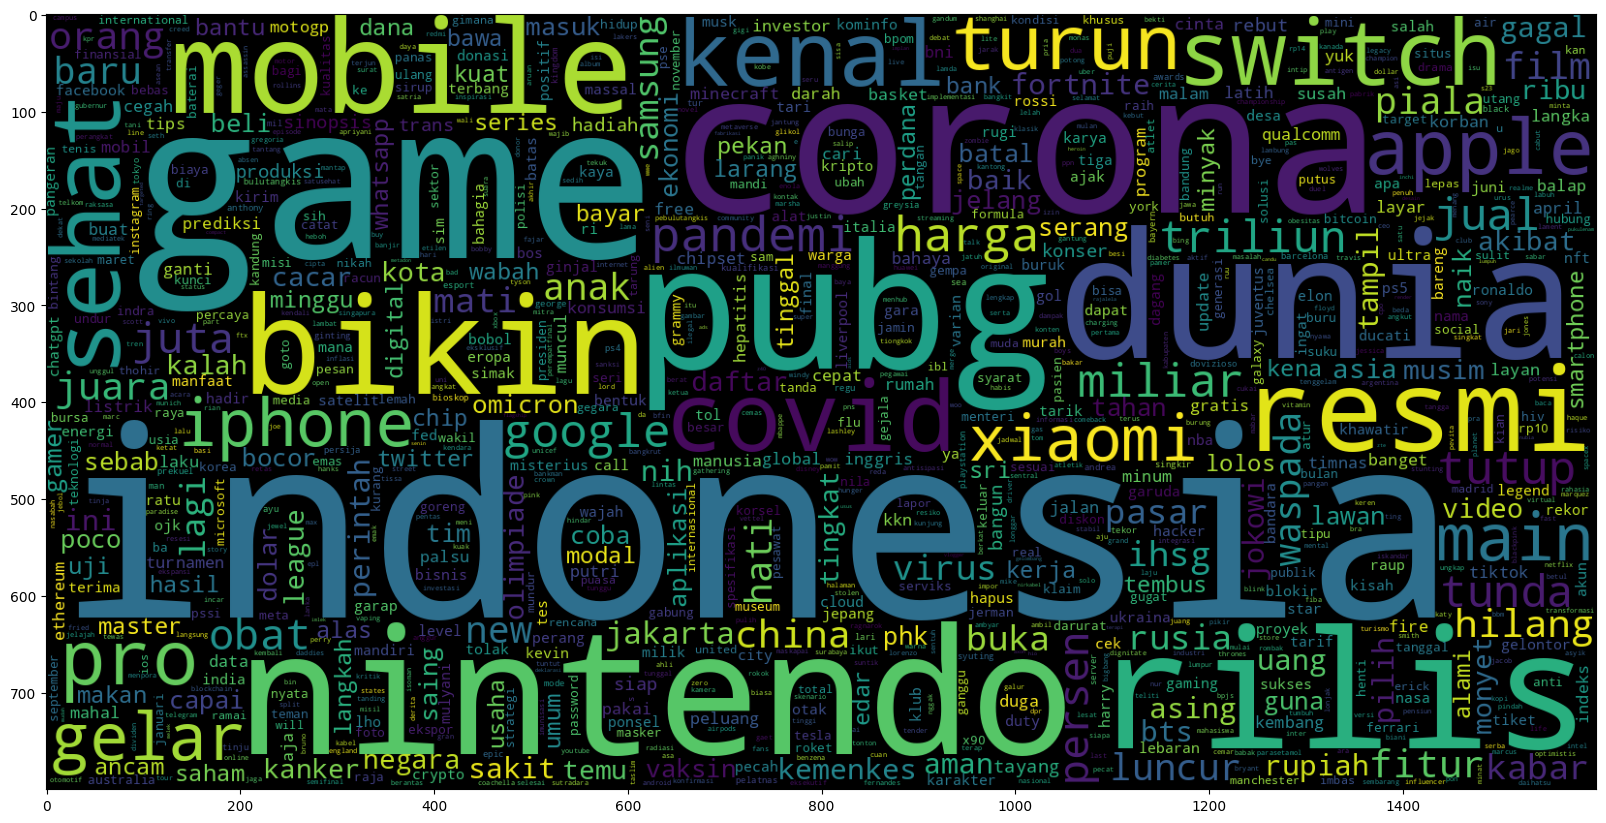

In [7]:
from wordcloud import WordCloud
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(articles_df['clean_text']))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [8]:
category = pd.get_dummies(articles_df.Jenis)
new_df = pd.concat([articles_df, category], axis=1)
new_df = new_df.drop(columns="Jenis")
new_df.head()

,Judul,clean_text,Finansial,Gaming,Hiburan,Kesehatan,Olahraga,Teknologi
0,Terapi Metadon Untuk Pecandu Heroin,terapi metadon candu heroin,0,0,0,1,0,0
1,Tesla Menuntut Seorang Influencer Vlogger Asal...,tesla tuntut influencer vlogger tiongkok alas,0,0,0,0,0,1
2,Lebih Melek pasar di Imlek 2022!,melek pasar imlek 2022,1,0,0,0,0,0
3,Indonesia Resmi Masuk Gelombang Tiga COVID-19,indonesia resmi masuk gelombang covid-19,0,0,0,1,0,0
4,"Bocoran Render Desain Xiaomi 12 Mini, Flagship...",bocor render desain xiaomi mini flagship compa...,0,0,0,0,0,1


In [9]:
# Convert topics to one-hot encoded vectors
features = ["Finansial", "Gaming", "Hiburan", "Kesehatan", "Olahraga", "Teknologi"]
titles = new_df['clean_text'].values
topics = new_df[features].values

In [10]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(titles, topics, test_size=0.1, random_state=42, shuffle=True)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 775 sentences for training.

There are 775 labels for training.

There are 87 sentences for validation.

There are 87 labels for validation.


In [47]:
NUM_WORDS = 3000
EMBEDDING_DIM = 100
MAXLEN = 100
PADDING = 'post'
OOV_TOKEN = "<OOV>"

In [48]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words , oov_token=oov_token)
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print(f"Vocabulary contains {len(word_index)} words\n")

Vocabulary contains 2366 words



In [49]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    return padded_sequences

train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (775, 100)

Padded validation sequences have shape: (87, 100)


In [57]:
def create_model(num_words, embedding_dim, maxlen):

    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2)),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  # optimizer=optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy']) 

    return model

In [58]:
from keras import optimizers
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_labels, epochs=10, validation_data=(val_padded_seq, val_labels), verbose=2)

Epoch 1/10
25/25 - 7s - loss: 1.7777 - accuracy: 0.2155 - val_loss: 1.7744 - val_accuracy: 0.1954 - 7s/epoch - 282ms/step
Epoch 2/10
25/25 - 2s - loss: 1.7163 - accuracy: 0.3097 - val_loss: 1.7071 - val_accuracy: 0.2069 - 2s/epoch - 100ms/step
Epoch 3/10
25/25 - 1s - loss: 1.4481 - accuracy: 0.6374 - val_loss: 1.3909 - val_accuracy: 0.5517 - 1s/epoch - 58ms/step
Epoch 4/10
25/25 - 2s - loss: 1.2340 - accuracy: 0.7548 - val_loss: 1.2776 - val_accuracy: 0.6667 - 2s/epoch - 62ms/step
Epoch 5/10
25/25 - 1s - loss: 0.6852 - accuracy: 0.8774 - val_loss: 1.0329 - val_accuracy: 0.7126 - 672ms/epoch - 27ms/step
Epoch 6/10
25/25 - 1s - loss: 0.3876 - accuracy: 0.9832 - val_loss: 0.7598 - val_accuracy: 0.8046 - 641ms/epoch - 26ms/step
Epoch 7/10
25/25 - 1s - loss: 0.1432 - accuracy: 0.9884 - val_loss: 0.6643 - val_accuracy: 0.8161 - 777ms/epoch - 31ms/step
Epoch 8/10
25/25 - 1s - loss: 0.0696 - accuracy: 0.9974 - val_loss: 0.6325 - val_accuracy: 0.7931 - 611ms/epoch - 24ms/step
Epoch 9/10
25/25 -

In [6]:
# model.save("model.h5")

In [5]:
# # Install tensorflowjs
# !pip install tensorflowjs

In [4]:
# # Convert model.h5 to model
# !tensorflowjs_converter --input_format=keras /content/model.h5 tfjs_model

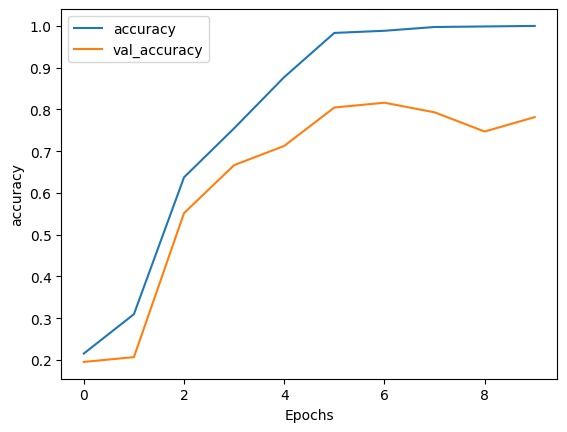

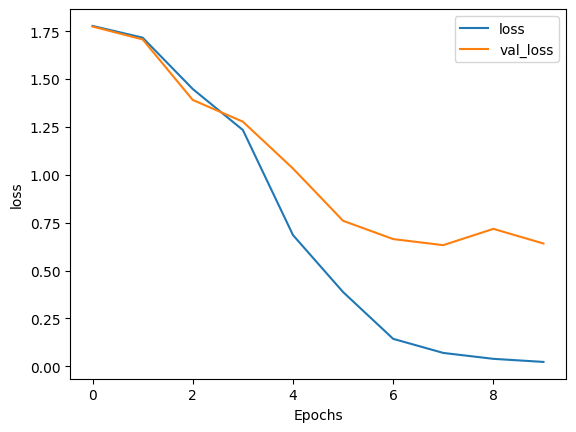

In [60]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [61]:
# Function to predict topic from news title
def predict_topic(title):
  clean = clean_text(title)
  padded_sequence = seq_and_pad([clean], tokenizer, PADDING, MAXLEN)
  prediction = model.predict(padded_sequence)
  topic_index = np.argmax(prediction)
  topic = features[topic_index]
  print(prediction)
  return topic

In [62]:
features

['Finansial', 'Gaming', 'Hiburan', 'Kesehatan', 'Olahraga', 'Teknologi']

In [63]:
# Input news title from user
# title = input("Enter a news title: ")
title = "Pameran Seni Kontemporer Menampilkan Karya-karya Inovatif dari Seniman Lokal dan Internasional"

# Analyze topic from news title
topic = predict_topic(title)

print(topic)

1/1 [==============================] - 1s 658ms/step
[[0.0024676  0.03890177 0.938963   0.00316862 0.00864476 0.00785426]]
Hiburan
